In [2]:
import os
import mne
import sklearn
import scipy.stats as stats
import pyedflib as edf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from math import ceil
%matplotlib inline

# Functions

In [3]:
def sub_epoch(epoch_list, dur):
    tmp = []
    for epoch in epoch_list.get_data():
        tmp.append(mne.make_fixed_length_epochs(mne.io.RawArray(epoch[:, :540*256], epoch_list.info), duration=dur))
    return tmp
    # return mne.concatenate_epochs(tmp) * Do not concat *

In [4]:
def shannon_entropy(psd):
    pk = psd/np.sum(psd)
    summation = -np.sum(pk * np.log(pk))
    res = -summation/np.log(len(psd))
    return res

In [5]:
def load_data(path):
    files = os.listdir(path)
    print(files)
    temp = [mne.io.read_raw_edf(f'{path}{f}', preload=True, verbose='error') for f in files]
    # merge all files into one
    data = mne.io.concatenate_raws(temp)
    # drop duplicate channel
    data = data.drop_channels('T8-P8-0')
    # select Gamma bound
    data = data.filter(l_freq=32, h_freq=120)
    return data

# Section A : Fetch Data
1. **fetch data** : fetch data from path and concat them into a integrate data variable.

In [6]:
path = './data/Sub3/WS3/'
path_nonseizure = './data/Sub3/WOS3/'

In [7]:
none_seizure = load_data(path_nonseizure)

In [8]:
seizure_data = load_data(path)

In [9]:
# extract seizure times for Sub3
#seizure_times= [chb03_02  ,   chb03_04   , chb03_34    , chb03_35   ,  chb03_36  ]
seizure_times = [[731, 796], [2162, 2214], [1982, 2029], [2592, 2656], [1725, 1778]]
# shift each time element 3600 seconds forward
for i, time in enumerate(seizure_times, 0):
    seizure_times[i] = list(map(lambda x: x + (i * 3600), time))

In [10]:
seizures = []
for start, end in seizure_times:
    seizures.append(mne.io.RawArray(seizure_data[:,int((start - 540)*256):int((start + 60)*256)][0], seizure_data.info))

In [11]:
none_times = [1080, 1800, 2340, 2890, 3440]

In [12]:
none_seiz_list = []
for start in none_times:
    none_seiz_list.append(mne.io.RawArray(none_seizure[:,int((start - 540)*256):int((start + 60)*256)][0], none_seizure.info))

In [13]:
x_train = seizures + none_seiz_list

In [14]:
x_train = mne.concatenate_raws(x_train)

# ploting seizures

In [18]:
ax, _ = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        for s, e in seizure_times:
            ax[i, j] = mne.io.RawArray(np.array(seizure_data[:, s*255:e*255][0]).reshape(22, (e-s)*255), seizure_data.info).plot()
plt.show()
    

# ploting none-seizures

Creating RawArray with float64 data, n_channels=22, n_times=137700
    Range : 0 ... 137699 =      0.000 ...   537.887 secs
Ready.


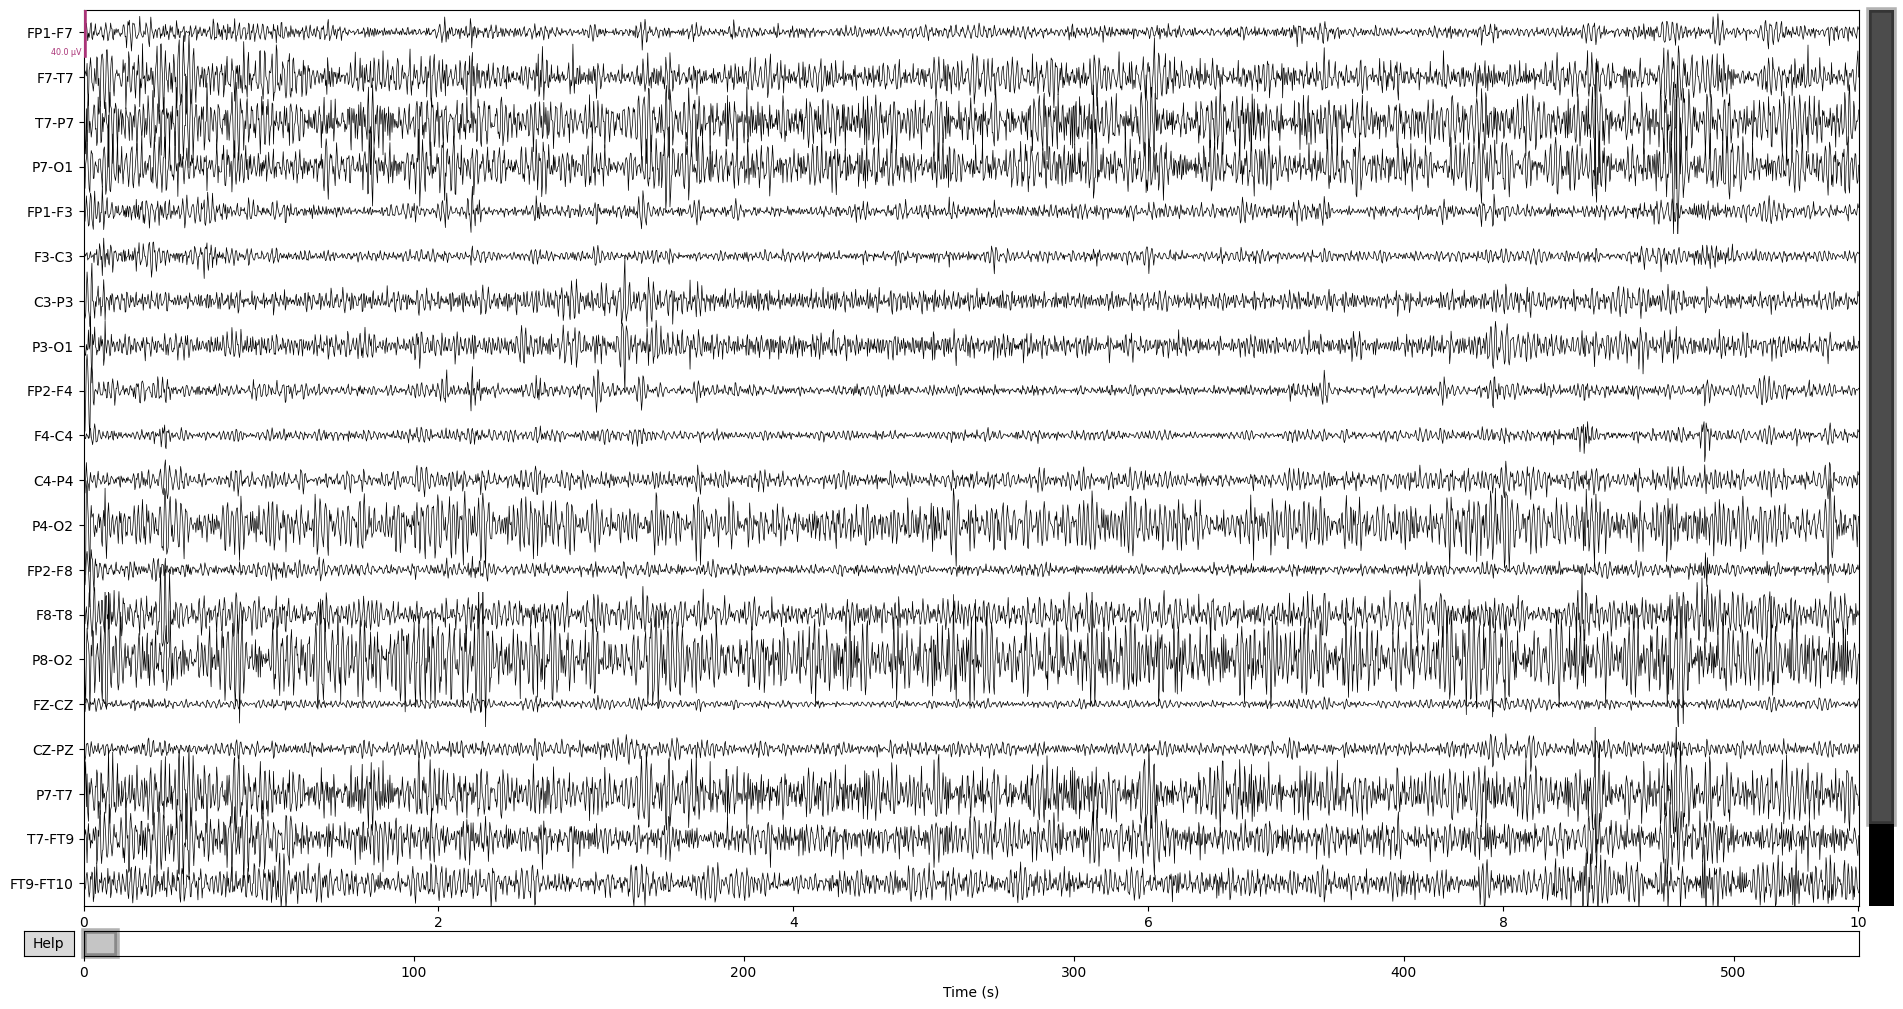

Creating RawArray with float64 data, n_channels=22, n_times=137700
    Range : 0 ... 137699 =      0.000 ...   537.887 secs
Ready.


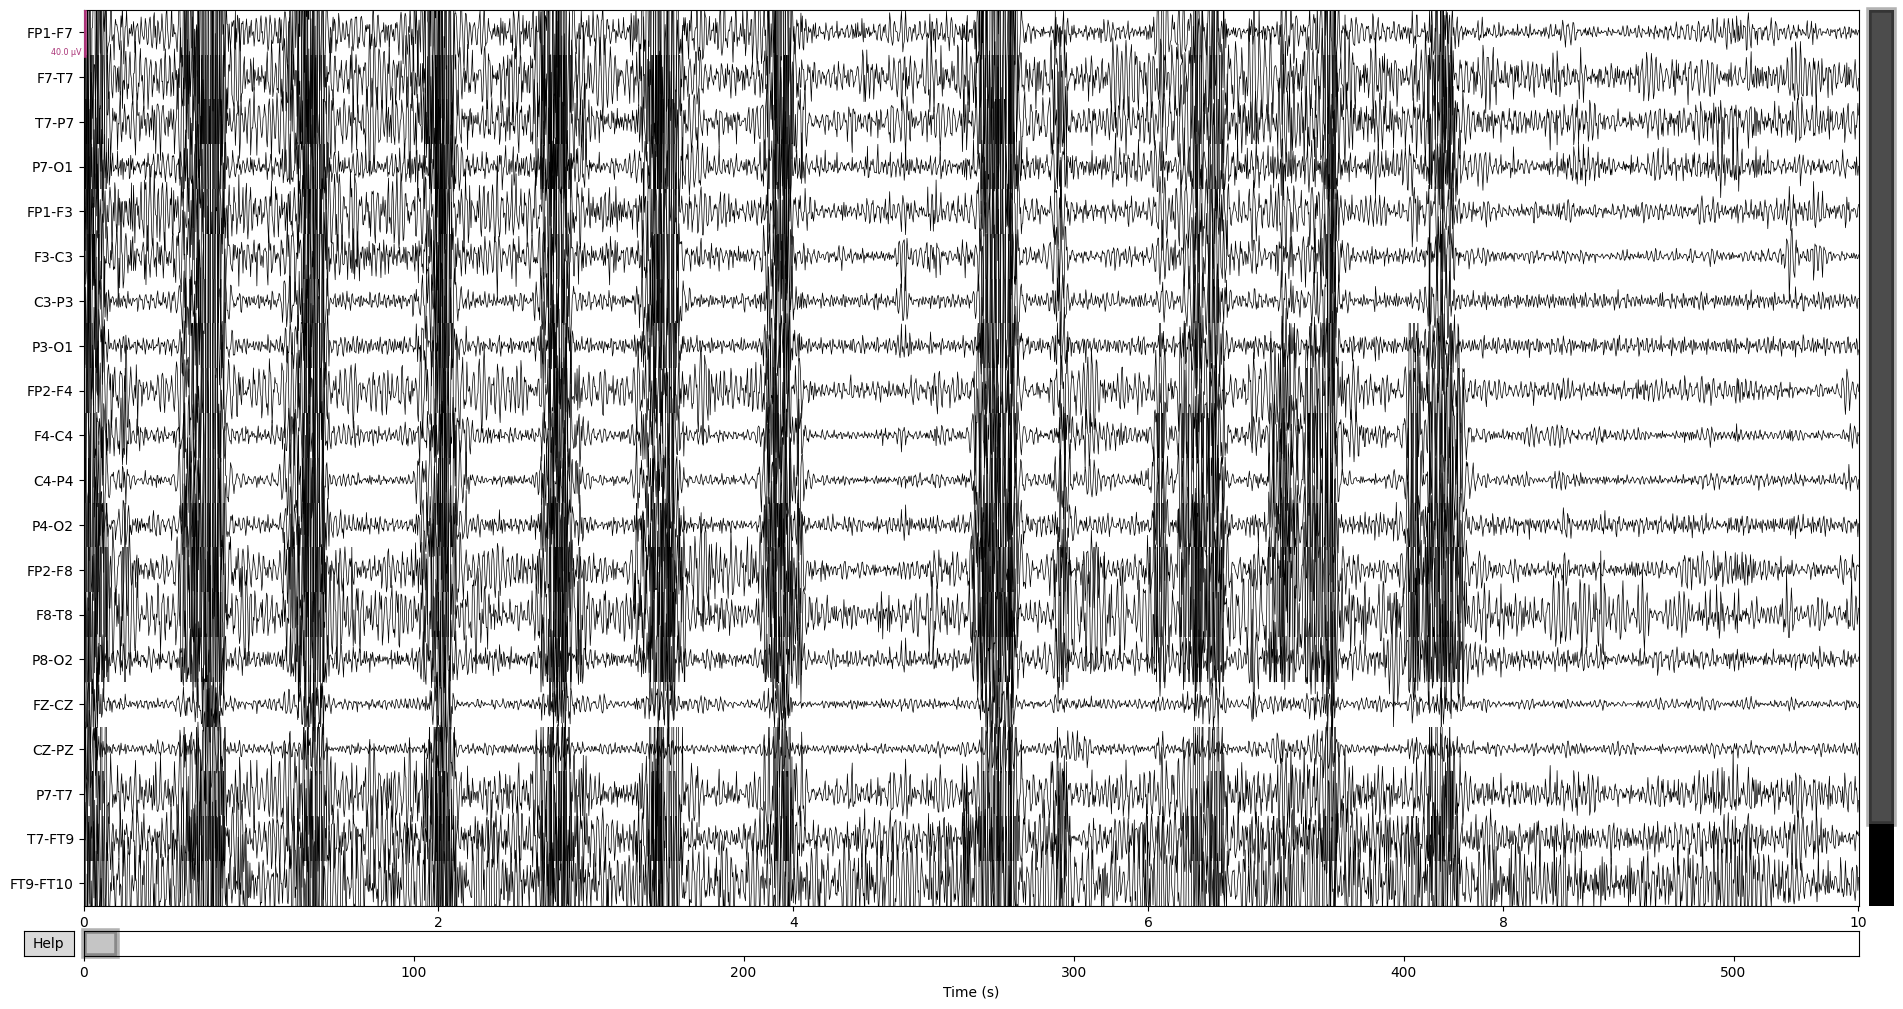

Creating RawArray with float64 data, n_channels=22, n_times=137700
    Range : 0 ... 137699 =      0.000 ...   537.887 secs
Ready.


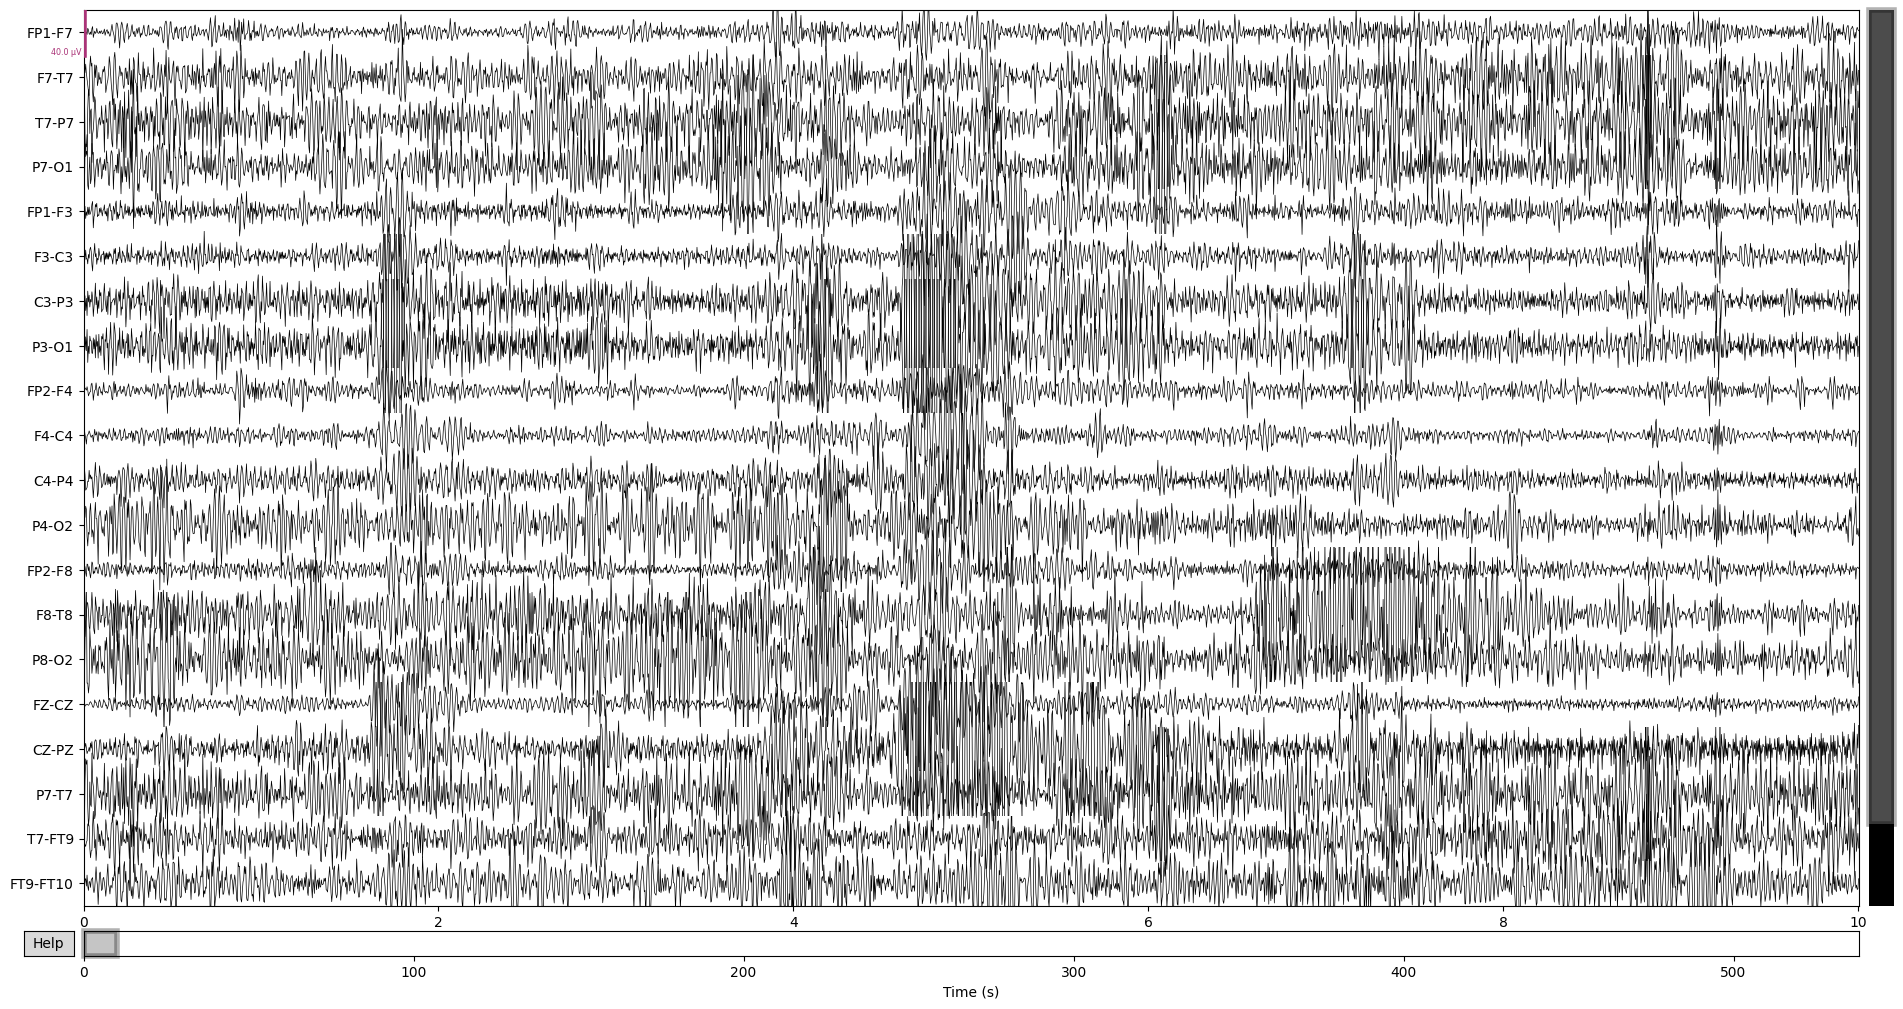

Creating RawArray with float64 data, n_channels=22, n_times=137700
    Range : 0 ... 137699 =      0.000 ...   537.887 secs
Ready.


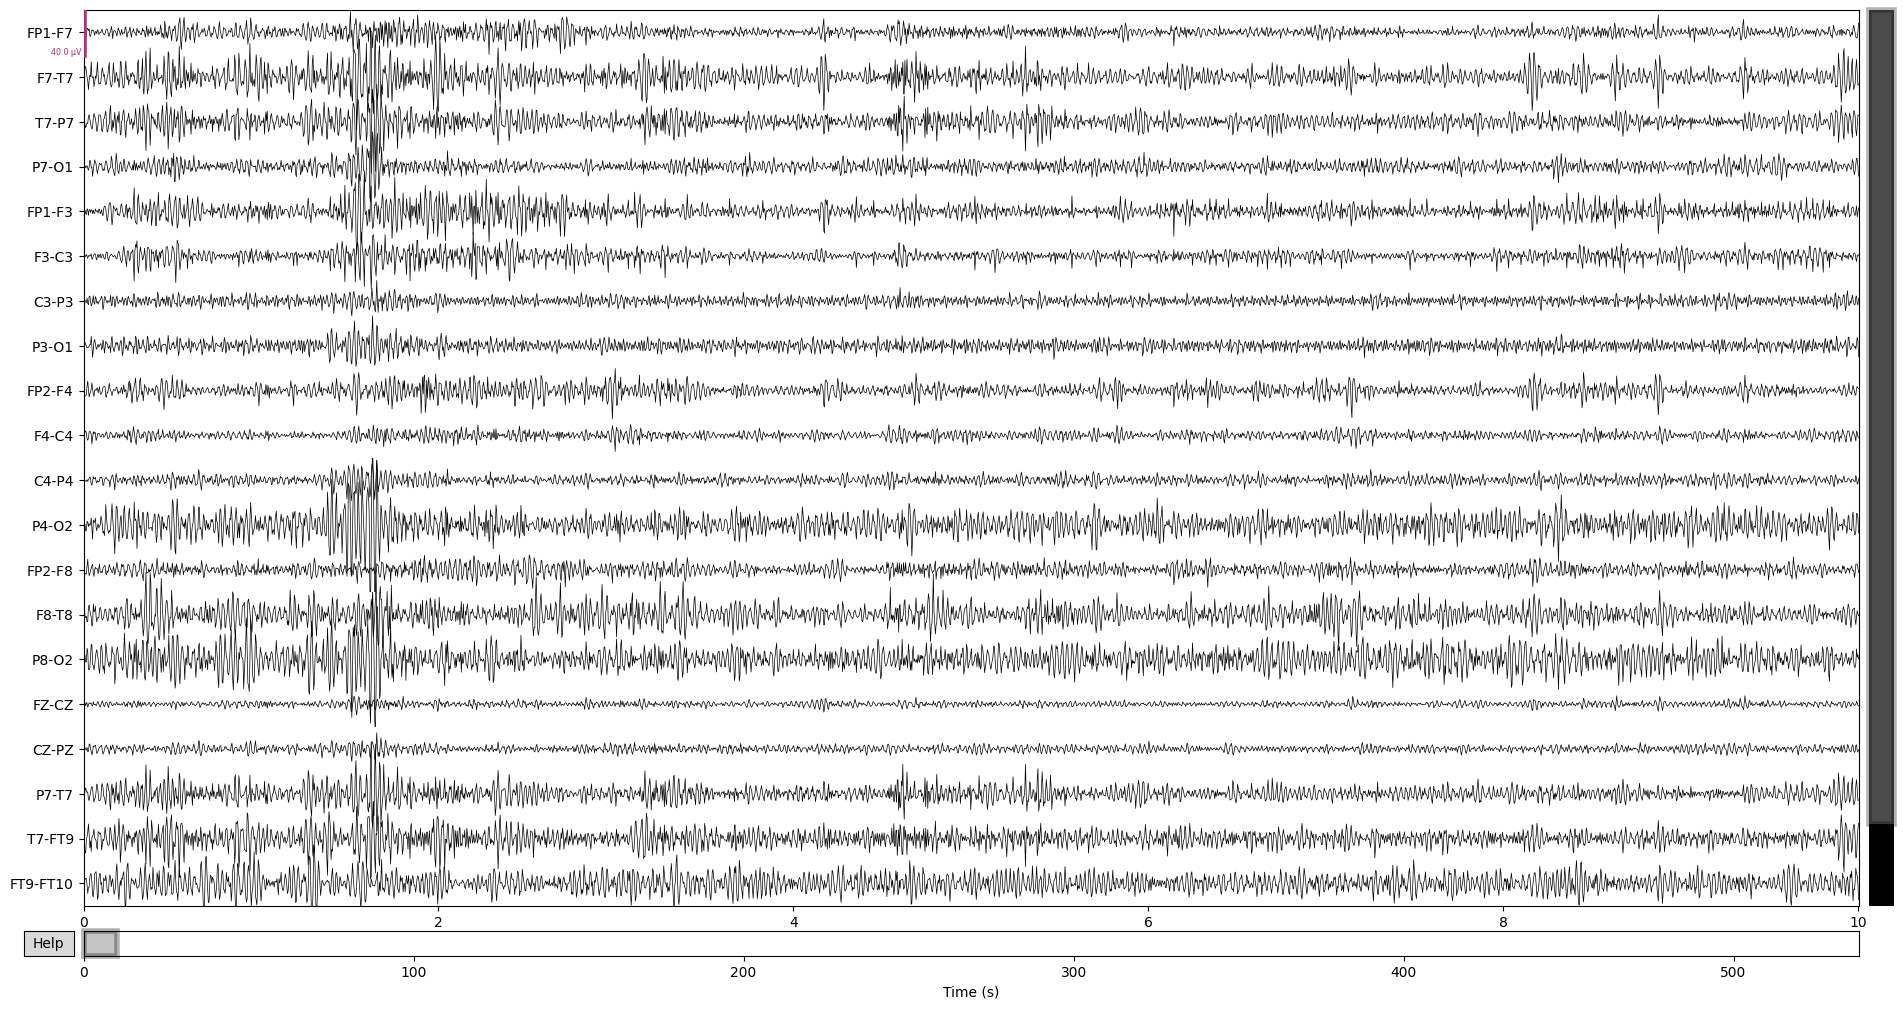

Creating RawArray with float64 data, n_channels=22, n_times=137700
    Range : 0 ... 137699 =      0.000 ...   537.887 secs
Ready.


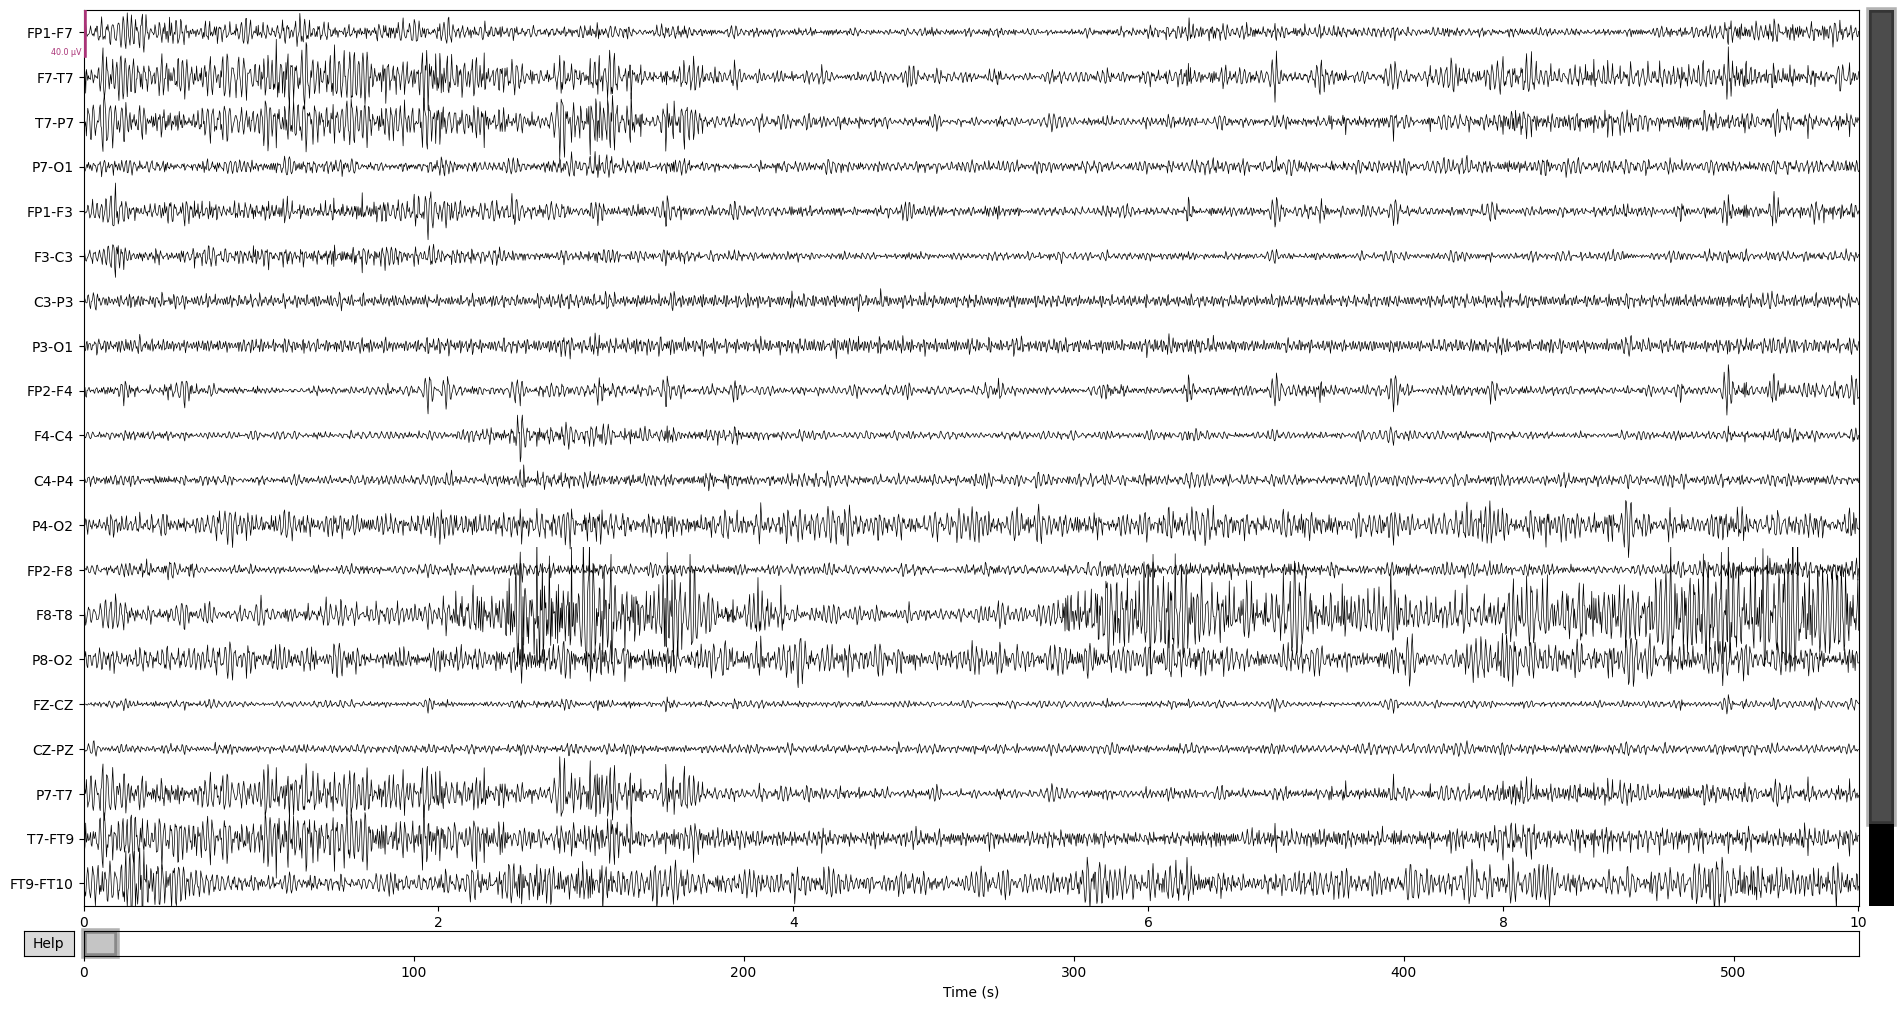

In [50]:
for i in none_times:
    mne.io.RawArray(np.array(none_seizure[:, (i-540)*255:i*255][0]).reshape(22, 540*255), none_seizure.info).plot()

# Section B : Calculating Power Spectral Density
1. **fetch data** : fetch data from path and concat them into a integrate data variable.
2. **psd** : A Power Spectral Density (PSD) is the measure of signal's power content versus frequency.

In [14]:
# create epochs
epochs = mne.make_fixed_length_epochs(x_train, duration=600, preload=True)

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 153600 original time points ...
0 bad epochs dropped


In [15]:
# create 16 seconds epochs per each 10 minutes epoch
devided_epochs = sub_epoch(epochs, 16)

Creating RawArray with float64 data, n_channels=22, n_times=138240
    Range : 0 ... 138239 =      0.000 ...   539.996 secs
Ready.
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=22, n_times=138240
    Range : 0 ... 138239 =      0.000 ...   539.996 secs
Ready.
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=22, n_times=138240
    Range : 0 ... 138239 =      0.000 ...   539.996 secs
Ready.
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=22, n_times=138240
    Range : 0 ... 138239 =      0.000 ...   539.996 secs
Ready.
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=22, 

/tmp/ipykernel_32842/553728945.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch in epoch_list.get_data():


# Section C & D : Calculating Shannon Entropy and Featuer Extraction  
1. **fetch data** : fetch data from path and concat them into a integrate data variable.
2. **psd** : A Power Spectral Density (PSD) is the measure of signal's power content versus frequency.
3. **shannon entropy** : we calculate shannon entropy for each psd of each 16 seconds epoch.

our features for the signals consist of:
> shannon entropy of each psd
>
> mean of each epoch
>
> standard deviation of each epoch
>
> min of each one
>
> max of each one

In [16]:
features = []
for epoch in devided_epochs:
    for event in epoch:
        epoch_feature = []
        for channel in event:
            psd, fre = mne.time_frequency.psd_array_welch(channel, sfreq=epochs.info['sfreq'])
            psd_entropy = shannon_entropy(psd)
            tmp = [psd_entropy, np.mean(channel), np.std(channel), np.min(channel), np.max(channel)]
            epoch_feature.extend(tmp)
        features.append(epoch_feature)
features = np.array(features)
features = features.reshape(10, -1)

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective wind

In [17]:
print(f"Total features: {features.shape}\nTotal size : {features.size}")

Total features: (10, 3630)
Total size : 36300


# Section E : Feature Selection
select features which p-value less than 0.001

In [36]:
t_stat, p_values = stats.ttest_1samp(features, 0)
features = features[:, p_values < 0.001]

In [37]:
print(f"Total features after feature selection are: {features.shape}\nTotal size : {features.size}")

Total features after feature selection are: (10, 885)
Total size : 8850


# Data labeling and spliting
1- we find the start time of each seizure (in second)

2- shift each one 1 hours forward because we merged edf files and length of each one is 1 hour

3- find related epoch of each one for labeling

In [47]:
labels = np.array([1,1,1,1,1,0,0,0,0,0])

In [48]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=3)

In [49]:
y_train

array([1, 0, 1, 0, 0, 1, 1])

# Define SVC Model

In [50]:
svm = SVC(kernel='rbf').fit(x_train, y_train)

# Define KNN Model

In [51]:
knn = KNeighborsClassifier(metric='minkowski').fit(x_train, y_train)

# Evaluate Model

In [52]:
svm_model_prediction = svm.predict(x_test)
knn_model_prediction = knn.predict(x_test)

In [53]:
print(f'svm score = {svm.score(x_test, y_test)}')
print(f'knn score = {knn.score(x_test, y_test)}')

svm score = 0.3333333333333333
knn score = 0.6666666666666666


In [54]:
# calculate f1-score for model
print(f1_score(y_test, svm_model_prediction, average='micro'))
print(f1_score(y_test, knn_model_prediction, average='micro'))

0.3333333333333333
0.6666666666666666


<Axes: >

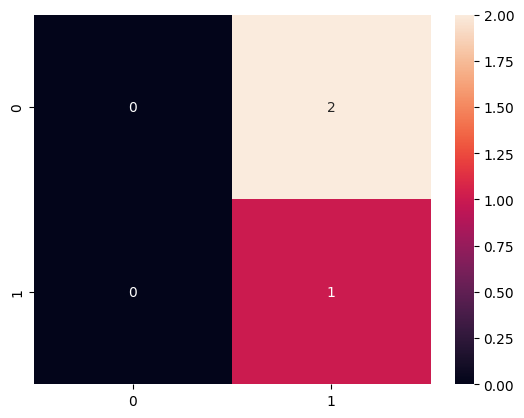

In [55]:
# calculating confusion matrix for svm
con_mat_svm = confusion_matrix(y_true=y_test, y_pred=svm_model_prediction)
sns.heatmap(con_mat_svm, annot=True)

<Axes: >

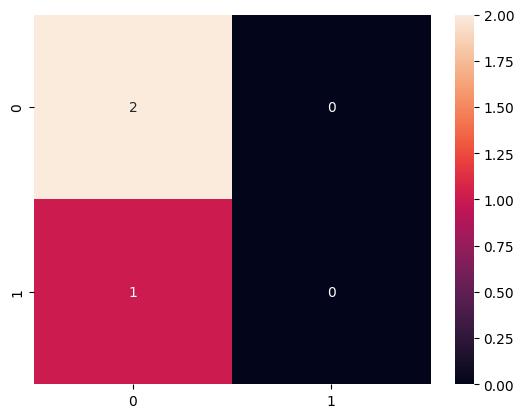

In [56]:
# calculating confusion matrix for svm
con_mat_knn = confusion_matrix(y_true=y_test, y_pred=knn_model_prediction)
sns.heatmap(con_mat_knn, annot=True)

In [57]:
senstivity_svm = (con_mat_svm[1][1] / (con_mat_svm[1][1] + con_mat_svm[1][0])) * 100
print(f'senstivity on SVC = {senstivity_svm}')
senstivity_knn = (con_mat_knn[1][1] / (con_mat_knn[1][1] + con_mat_knn[1][0])) * 100
print(f'senstivity on KNN = {senstivity_knn}')

senstivity on SVC = 100.0
senstivity on KNN = 0.0


In [58]:
specificity_svm = (con_mat_svm[0][0] / (con_mat_svm[0][0] + con_mat_svm[0][1])) * 100
print(f'specificity on SVC = {specificity_svm}')
specificity_knn = (con_mat_knn[0][0] / (con_mat_knn[0][0] + con_mat_knn[0][1])) * 100
print(f'specificity on KNN = {specificity_knn}')

specificity on SVC = 0.0
specificity on KNN = 100.0
